# Comparing scenarios for West Africa

We are interested in extracting the value of the total yearly emissions of CO, NOx, SO2, NH3 in different years and compare those values across scenarios

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from area import area

In [2]:
seconds_in_year = 31536000
#area_earth = 5.1006447295*pow(10,14)
NO2_molar_mass = 46.006 #g/mol
NO_molar_mass =  30.006 #g/mol

We have data fom three SSP scenarios, spanning the times from January 2015 to December 2100:

In [3]:
# ROAD emissions
file_ssp119_road_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp119_road_MISC_201501-210012.nc'
file_ssp245_road_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp245_road_MISC_201501-210012.nc'
file_ssp370_road_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp370_road_MISC_201501-210012.nc'

# SHIP emissions
file_ssp119_ship_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp119_ship_MISC_201501-210012.nc'
file_ssp245_ship_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp245_ship_MISC_201501-210012.nc'
file_ssp370_ship_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp370_ship_MISC_201501-210012.nc'

# LAND emissions, excluding ROAD, SHIP, AWB
file_ssp119_land_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp119_land-road-awb_MISC_201501-210012.nc'
file_ssp245_land_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp245_land-road-awb_MISC_201501-210012.nc'
file_ssp370_land_2015_2100 = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp370_land-road-awb_MISC_201501-210012.nc'

In [4]:
# 'lev' has only one value, and it messes with the coordinates order. Drop it for ease of plot
data_ssp119_road_2015_2100 = xr.open_dataset(file_ssp119_road_2015_2100).drop('lev')
data_ssp245_road_2015_2100 = xr.open_dataset(file_ssp245_road_2015_2100).drop('lev')
data_ssp370_road_2015_2100 = xr.open_dataset(file_ssp370_road_2015_2100).drop('lev')

data_ssp119_ship_2015_2100 = xr.open_dataset(file_ssp119_ship_2015_2100).drop('lev')
data_ssp245_ship_2015_2100 = xr.open_dataset(file_ssp245_ship_2015_2100).drop('lev')
data_ssp370_ship_2015_2100 = xr.open_dataset(file_ssp370_ship_2015_2100).drop('lev')

data_ssp119_land_2015_2100 = xr.open_dataset(file_ssp119_land_2015_2100).drop('lev')
data_ssp245_land_2015_2100 = xr.open_dataset(file_ssp245_land_2015_2100).drop('lev')
data_ssp370_land_2015_2100 = xr.open_dataset(file_ssp370_land_2015_2100).drop('lev')

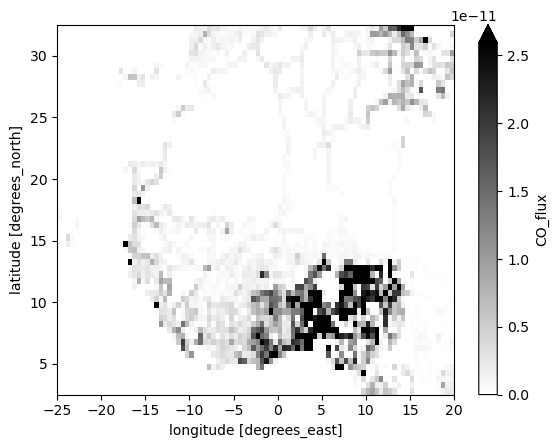

In [5]:
# selecting only West Africa:

data_ssp119_road_2015_2100_w_africa = data_ssp119_road_2015_2100.isel(lat=slice(185, 245), lon = slice(310,400))
data_ssp119_road_2015_2100_w_africa['CO_flux'].mean('time').plot(robust=True, cmap=plt.cm.binary)

In [6]:
lats_wa = data_ssp119_road_2015_2100_w_africa.lat
lons_wa = data_ssp119_road_2015_2100_w_africa.lon

In [7]:
def area_polygon(coordinates):
    obj = {'type':'Polygon','coordinates':coordinates}
    return area(obj)

In [8]:
lat1_wa = lats_wa[0]
lat2_wa = lats_wa[-1:]

lon1_wa = lons_wa[0]
lon2_wa = lons_wa[-1:]

In [22]:
area_wafrica = area_polygon([[[lon1_wa,lat1_wa],[lon1_wa,lat2_wa],[lon2_wa,lat2_wa],[lon2_wa,lat1_wa],[lon1_wa,lat1_wa]]]).item()

In [31]:
# returns total yearly average emission in Tg
def yearly_global_weighted_averages_w_africa(data, specie = 'CO', area_region = area_wafrica):
    # Select Europe
    data_region = data.isel(lat=slice(185, 245), lon = slice(310,400))
    
    # Average over each year's monthly values to get the yearly values
    emission = data_region[specie + '_flux'].resample(time="1YS").mean(dim="time")
    
    # Create a weight array for the zonal average
    weight_emission = np.cos(np.deg2rad(emission.lat)) #deg2rad converts the latitude from degrees to radians
    weight_emission = weight_emission / weight_emission.sum() #weigh each latitudinal band by dividing it by the summed weights

    # Average over lon, zonal average over lan
    emission_lon = emission.mean(dim='lon')
    emission_weighted = []
    for year in range(emission.shape[0]):
        emission_weighted.append(np.sum(emission_lon[year, :, :] * weight_emission).data *  area_region * pow(10, -9) * seconds_in_year)
    
    # The flux of NOx is in kg(NO2)/m^2/s, but to better compare it with other inventories we want it in kg(NO)/m^2/s
    if specie == 'NOx':
        emission_weighted = list(np.array(emission_weighted)/NO2_molar_mass*NO_molar_mass)

    return emission_weighted 

In [32]:
# ROAD
CO_ssp119_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_road_2015_2100, 'CO')
NH3_ssp119_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_road_2015_2100, 'NH3')
NOx_ssp119_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_road_2015_2100, 'NOx')
SO2_ssp119_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_road_2015_2100, 'SO2')

CO_ssp245_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_road_2015_2100, 'CO')
NH3_ssp245_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_road_2015_2100, 'NH3')
NOx_ssp245_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_road_2015_2100, 'NOx')
SO2_ssp245_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_road_2015_2100, 'SO2')

CO_ssp370_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_road_2015_2100, 'CO')
NH3_ssp370_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_road_2015_2100, 'NH3')
NOx_ssp370_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_road_2015_2100, 'NOx')
SO2_ssp370_road_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_road_2015_2100, 'SO2')

In [33]:
# SHIP
CO_ssp119_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_ship_2015_2100, 'CO')
NH3_ssp119_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_ship_2015_2100, 'NH3')
NOx_ssp119_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_ship_2015_2100, 'NOx')
SO2_ssp119_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_ship_2015_2100, 'SO2')

CO_ssp245_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_ship_2015_2100, 'CO')
NH3_ssp245_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_ship_2015_2100, 'NH3')
NOx_ssp245_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_ship_2015_2100, 'NOx')
SO2_ssp245_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_ship_2015_2100, 'SO2')

CO_ssp370_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_ship_2015_2100, 'CO')
NH3_ssp370_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_ship_2015_2100, 'NH3')
NOx_ssp370_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_ship_2015_2100, 'NOx')
SO2_ssp370_ship_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_ship_2015_2100, 'SO2')

In [34]:
# LAND - ROAD - AWB
CO_ssp119_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_land_2015_2100, 'CO')
NH3_ssp119_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_land_2015_2100, 'NH3')
NOx_ssp119_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_land_2015_2100, 'NOx')
SO2_ssp119_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp119_land_2015_2100, 'SO2')

CO_ssp245_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_land_2015_2100, 'CO')
NH3_ssp245_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_land_2015_2100, 'NH3')
NOx_ssp245_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_land_2015_2100, 'NOx')
SO2_ssp245_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp245_land_2015_2100, 'SO2')

CO_ssp370_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_land_2015_2100, 'CO')
NH3_ssp370_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_land_2015_2100, 'NH3')
NOx_ssp370_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_land_2015_2100, 'NOx')
SO2_ssp370_land_yearly_global_weighted_averages = yearly_global_weighted_averages_w_africa(data_ssp370_land_2015_2100, 'SO2')

### Comparisons of different species in the same scenario for road emissions

In [35]:
emissions_ssp119_road = pd.DataFrame({'CO': CO_ssp119_road_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp119_road_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp119_road_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp119_road_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp245_road = pd.DataFrame({'CO': CO_ssp245_road_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp245_road_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp245_road_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp245_road_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp370_road = pd.DataFrame({'CO': CO_ssp370_road_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp370_road_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp370_road_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp370_road_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))

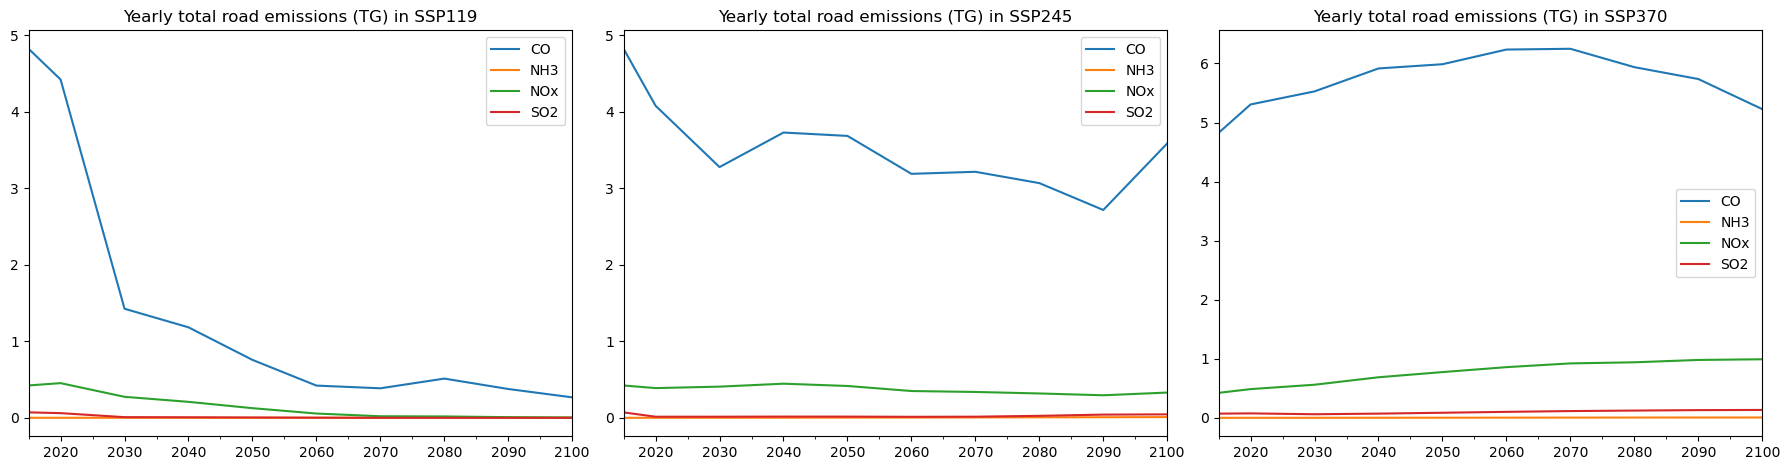

In [36]:
fig1, axs1 = plt.subplots(1,3)
fig1.set_figwidth(18)

emissions_ssp119_road.plot(title = 'Yearly total road emissions (TG) in SSP119', ax= axs1[0])
emissions_ssp245_road.plot(title = 'Yearly total road emissions (TG) in SSP245', ax= axs1[1])
emissions_ssp370_road.plot(title = 'Yearly total road emissions (TG) in SSP370', ax= axs1[2])

fig1.tight_layout()

### Comparisons of different species in the same scenario for ship emissions

In [37]:
emissions_ssp119_ship = pd.DataFrame({'CO': CO_ssp119_ship_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp119_ship_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp119_ship_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp119_ship_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp245_ship = pd.DataFrame({'CO': CO_ssp245_ship_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp245_ship_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp245_ship_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp245_ship_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp370_ship = pd.DataFrame({'CO': CO_ssp370_ship_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp370_ship_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp370_ship_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp370_ship_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))

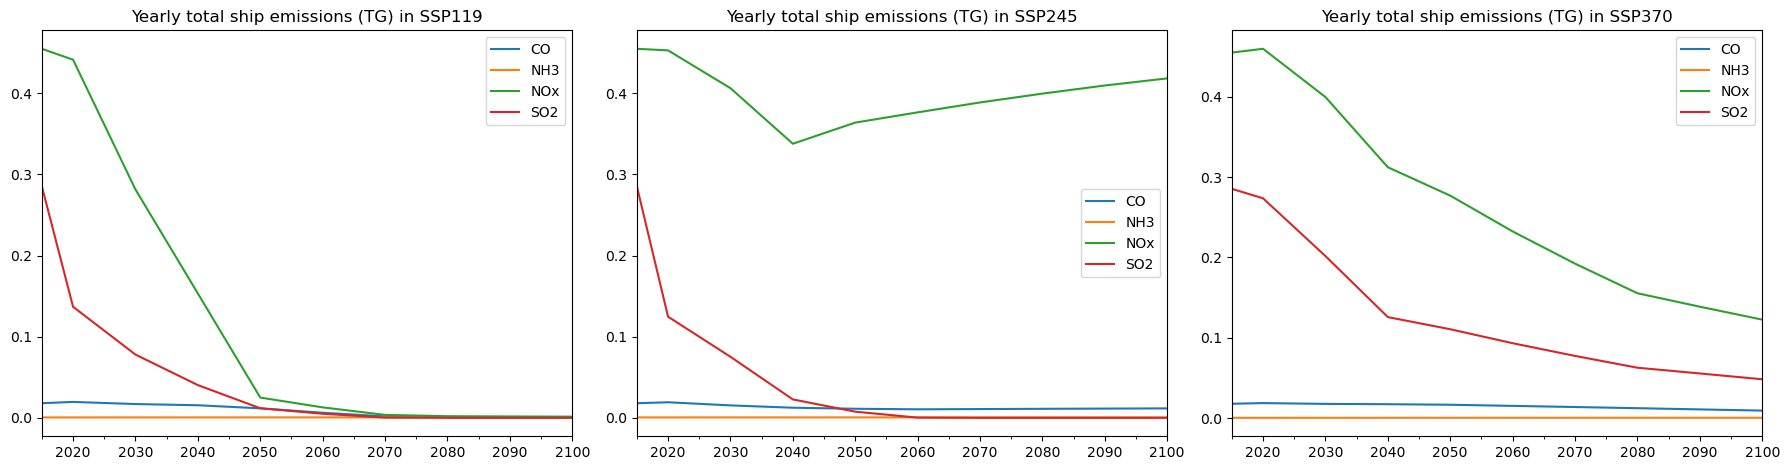

In [38]:
fig2, axs2 = plt.subplots(1,3)
fig2.set_figwidth(18)

emissions_ssp119_ship.plot(title = 'Yearly total ship emissions (TG) in SSP119', ax= axs2[0])
emissions_ssp245_ship.plot(title = 'Yearly total ship emissions (TG) in SSP245', ax= axs2[1])
emissions_ssp370_ship.plot(title = 'Yearly total ship emissions (TG) in SSP370', ax= axs2[2])

fig2.tight_layout()

### Comparisons of different species in the same scenario for land emissions, excluding road and awb

In [39]:
emissions_ssp119_land = pd.DataFrame({'CO': CO_ssp119_land_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp119_land_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp119_land_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp119_land_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp245_land = pd.DataFrame({'CO': CO_ssp245_land_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp245_land_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp245_land_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp245_land_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_ssp370_land = pd.DataFrame({'CO': CO_ssp370_land_yearly_global_weighted_averages,
                                 'NH3': NH3_ssp370_land_yearly_global_weighted_averages, 
                                 'NOx': NOx_ssp370_land_yearly_global_weighted_averages, 
                                 'SO2': SO2_ssp370_land_yearly_global_weighted_averages},
                               index=pd.date_range("1/1/2015", periods=86, freq='Y'))

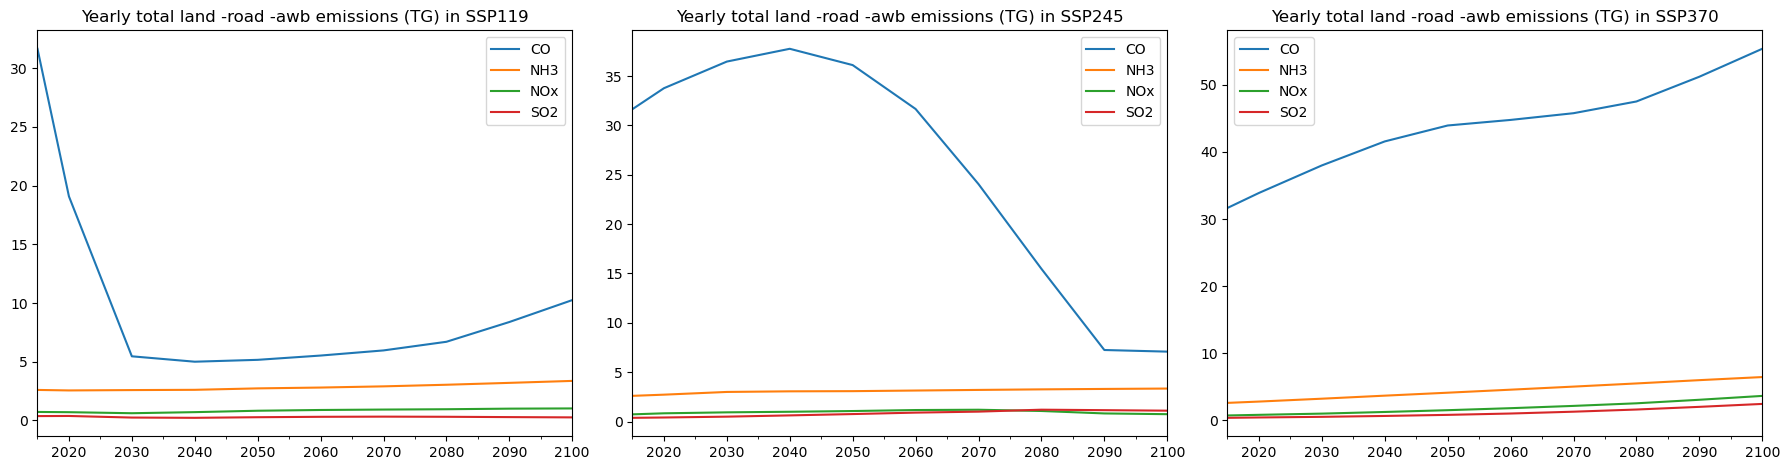

In [40]:
fig3, axs3 = plt.subplots(1,3)
fig3.set_figwidth(18)

emissions_ssp119_land.plot(title = 'Yearly total land -road -awb emissions (TG) in SSP119', ax= axs3[0])
emissions_ssp245_land.plot(title = 'Yearly total land -road -awb emissions (TG) in SSP245', ax= axs3[1])
emissions_ssp370_land.plot(title = 'Yearly total land -road -awb emissions (TG) in SSP370', ax= axs3[2])

fig3.tight_layout()

### Comparisons of the same specie in different scenarios for road emissions

In [41]:
emissions_CO_road = pd.DataFrame({'SSP119': CO_ssp119_road_yearly_global_weighted_averages,
                             'SSP245': CO_ssp245_road_yearly_global_weighted_averages,
                             'SSP370': CO_ssp370_road_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NH3_road = pd.DataFrame({'SSP119': NH3_ssp119_road_yearly_global_weighted_averages,
                             'SSP245': NH3_ssp245_road_yearly_global_weighted_averages,
                             'SSP370': NH3_ssp370_road_yearly_global_weighted_averages},
                            index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NOx_road = pd.DataFrame({'SSP119': NOx_ssp119_road_yearly_global_weighted_averages,
                             'SSP245': NOx_ssp245_road_yearly_global_weighted_averages,
                             'SSP370': NOx_ssp370_road_yearly_global_weighted_averages},
                            index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_SO2_road = pd.DataFrame({'SSP119': SO2_ssp119_road_yearly_global_weighted_averages,
                             'SSP245': SO2_ssp245_road_yearly_global_weighted_averages,
                             'SSP370': SO2_ssp370_road_yearly_global_weighted_averages}, 
                             index=pd.date_range("1/1/2015", periods=86, freq='Y'))

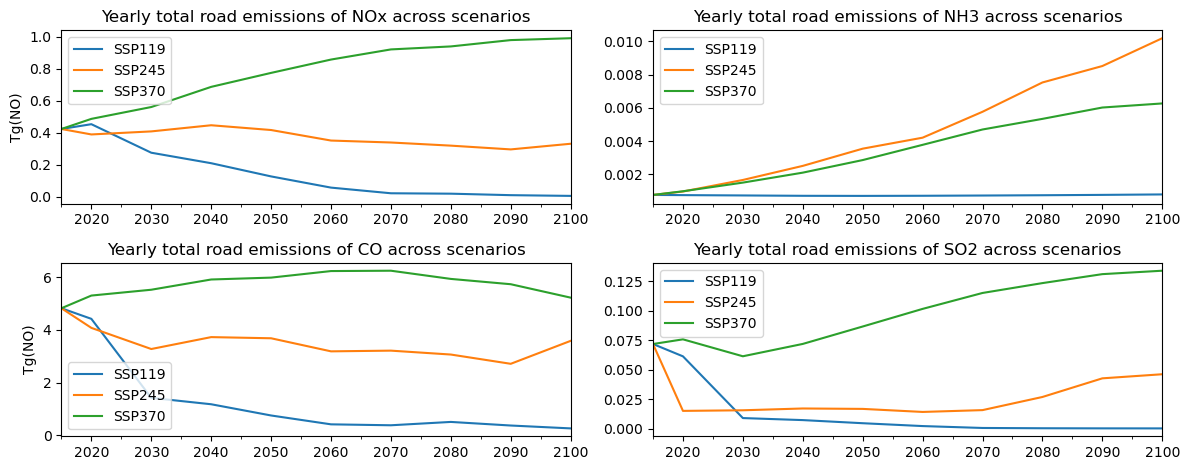

In [42]:
fig4, axs4 = plt.subplots(2,2)
fig4.set_figwidth(12)

emissions_NOx_road.plot(title = 'Yearly total road emissions of NOx across scenarios', ax= axs4[0,0])
axs4[0,0].set_ylabel('Tg(NO)')

emissions_NH3_road.plot(title = 'Yearly total road emissions of NH3 across scenarios', ax= axs4[0,1])
emissions_CO_road.plot(title = 'Yearly total road emissions of CO across scenarios', ax= axs4[1,0])
emissions_SO2_road.plot(title = 'Yearly total road emissions of SO2 across scenarios', ax= axs4[1,1])

axs4[1,0].set_ylabel('Tg(NO)')

fig4.tight_layout()

### Comparisons of the same specie in different scenarios for ship emissions

In [43]:
emissions_CO_ship = pd.DataFrame({'SSP119': CO_ssp119_ship_yearly_global_weighted_averages,
                             'SSP245': CO_ssp245_ship_yearly_global_weighted_averages,
                             'SSP370': CO_ssp370_ship_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NH3_ship = pd.DataFrame({'SSP119': NH3_ssp119_ship_yearly_global_weighted_averages,
                             'SSP245': NH3_ssp245_ship_yearly_global_weighted_averages,
                             'SSP370': NH3_ssp370_ship_yearly_global_weighted_averages},
                            index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NOx_ship = pd.DataFrame({'SSP119': NOx_ssp119_ship_yearly_global_weighted_averages,
                             'SSP245': NOx_ssp245_ship_yearly_global_weighted_averages,
                             'SSP370': NOx_ssp370_ship_yearly_global_weighted_averages},
                            index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_SO2_ship = pd.DataFrame({'SSP119': SO2_ssp119_ship_yearly_global_weighted_averages,
                             'SSP245': SO2_ssp245_ship_yearly_global_weighted_averages,
                             'SSP370': SO2_ssp370_ship_yearly_global_weighted_averages}, 
                             index=pd.date_range("1/1/2015", periods=86, freq='Y'))

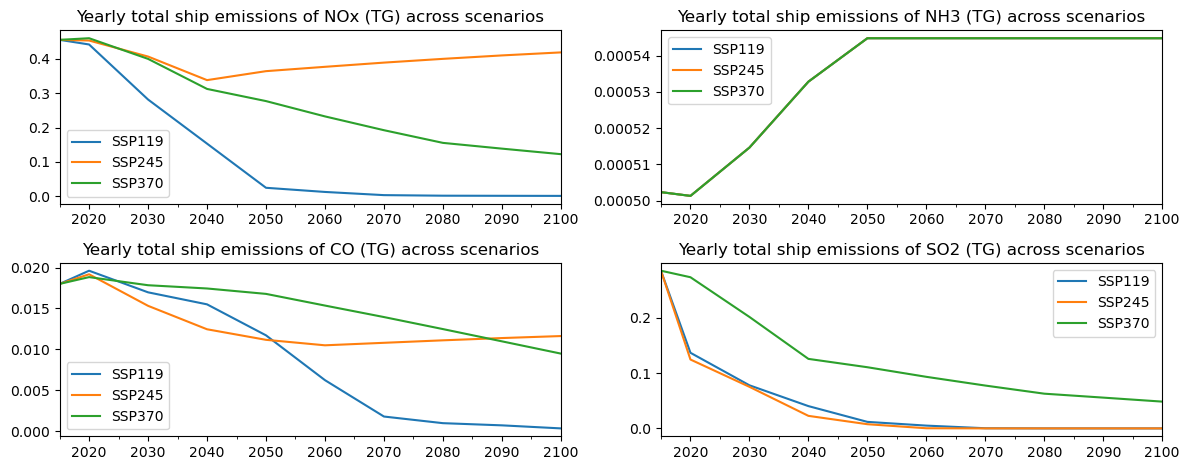

In [44]:
fig5, axs5 = plt.subplots(2,2)
fig5.set_figwidth(12)

emissions_NOx_ship.plot(title = 'Yearly total ship emissions of NOx (TG) across scenarios', ax= axs5[0,0])
emissions_NH3_ship.plot(title = 'Yearly total ship emissions of NH3 (TG) across scenarios', ax= axs5[0,1])
emissions_CO_ship.plot(title = 'Yearly total ship emissions of CO (TG) across scenarios', ax= axs5[1,0])
emissions_SO2_ship.plot(title = 'Yearly total ship emissions of SO2 (TG) across scenarios', ax= axs5[1,1])

fig5.tight_layout()

The graph for NH3 looks weird because all the scenarios have exactly the same value for NH3 ship emissions

### Comparisons of the same specie in different scenarios for land emissions, excluding road and AWB

In [45]:
emissions_CO_land = pd.DataFrame({'SSP119': CO_ssp119_land_yearly_global_weighted_averages,
                             'SSP245': CO_ssp245_land_yearly_global_weighted_averages,
                             'SSP370': CO_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NH3_land = pd.DataFrame({'SSP119': NH3_ssp119_land_yearly_global_weighted_averages,
                             'SSP245': NH3_ssp245_land_yearly_global_weighted_averages,
                             'SSP370': NH3_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NOx_land = pd.DataFrame({'SSP119': NOx_ssp119_land_yearly_global_weighted_averages,
                             'SSP245': NOx_ssp245_land_yearly_global_weighted_averages,
                             'SSP370': NOx_ssp370_land_yearly_global_weighted_averages},
                            index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_SO2_land = pd.DataFrame({'SSP119': SO2_ssp119_land_yearly_global_weighted_averages,
                             'SSP245': SO2_ssp245_land_yearly_global_weighted_averages,
                             'SSP370': SO2_ssp370_land_yearly_global_weighted_averages}, 
                             index=pd.date_range("1/1/2015", periods=86, freq='Y'))

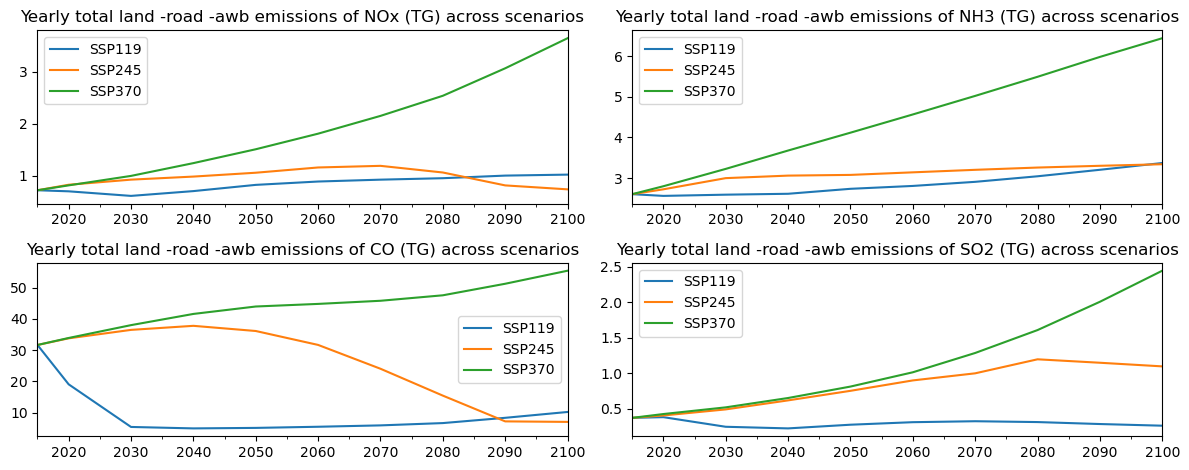

In [46]:
fig6, axs6 = plt.subplots(2,2)
fig6.set_figwidth(12)

emissions_NOx_land.plot(title = 'Yearly total land -road -awb emissions of NOx (TG) across scenarios', ax= axs6[0,0])
emissions_NH3_land.plot(title = 'Yearly total land -road -awb emissions of NH3 (TG) across scenarios', ax= axs6[0,1])
emissions_CO_land.plot(title = 'Yearly total land -road -awb emissions of CO (TG) across scenarios', ax= axs6[1,0])
emissions_SO2_land.plot(title = 'Yearly total land -road -awb emissions of SO2 (TG) across scenarios', ax= axs6[1,1])

fig6.tight_layout()

## Comparing the same species, the same scenario, for different categories

### CO, across scenarios, for different categories

In [47]:
emissions_CO_ssp119 = pd.DataFrame({'road': CO_ssp119_road_yearly_global_weighted_averages,
                             'ship': CO_ssp119_ship_yearly_global_weighted_averages,
                             'land': CO_ssp119_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_CO_ssp245 = pd.DataFrame({'road': CO_ssp245_road_yearly_global_weighted_averages,
                             'ship': CO_ssp245_ship_yearly_global_weighted_averages,
                             'land': CO_ssp245_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_CO_ssp370 = pd.DataFrame({'road': CO_ssp370_road_yearly_global_weighted_averages,
                             'ship': CO_ssp370_ship_yearly_global_weighted_averages,
                             'land': CO_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))

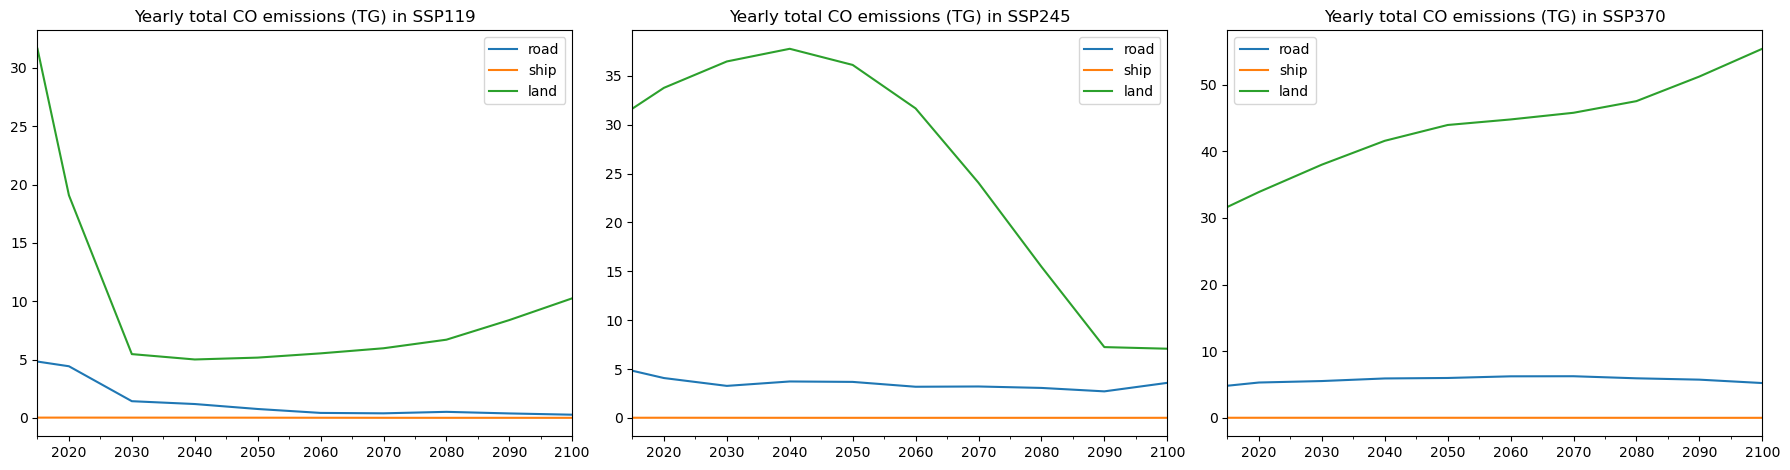

In [48]:
fig7, axs7 = plt.subplots(1,3)
fig7.set_figwidth(18)

emissions_CO_ssp119.plot(title = 'Yearly total CO emissions (TG) in SSP119', ax= axs7[0])
emissions_CO_ssp245.plot(title = 'Yearly total CO emissions (TG) in SSP245', ax= axs7[1])
emissions_CO_ssp370.plot(title = 'Yearly total CO emissions (TG) in SSP370', ax= axs7[2])

fig7.tight_layout()

### NH3, across scenarios, for different categories

In [49]:
emissions_NH3_ssp119 = pd.DataFrame({'road': NH3_ssp119_road_yearly_global_weighted_averages,
                             'ship': NH3_ssp119_ship_yearly_global_weighted_averages,
                             'land': NH3_ssp119_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NH3_ssp245 = pd.DataFrame({'road': NH3_ssp245_road_yearly_global_weighted_averages,
                             'ship': NH3_ssp245_ship_yearly_global_weighted_averages,
                             'land': NH3_ssp245_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NH3_ssp370 = pd.DataFrame({'road': NH3_ssp370_road_yearly_global_weighted_averages,
                             'ship': NH3_ssp370_ship_yearly_global_weighted_averages,
                             'land': NH3_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))

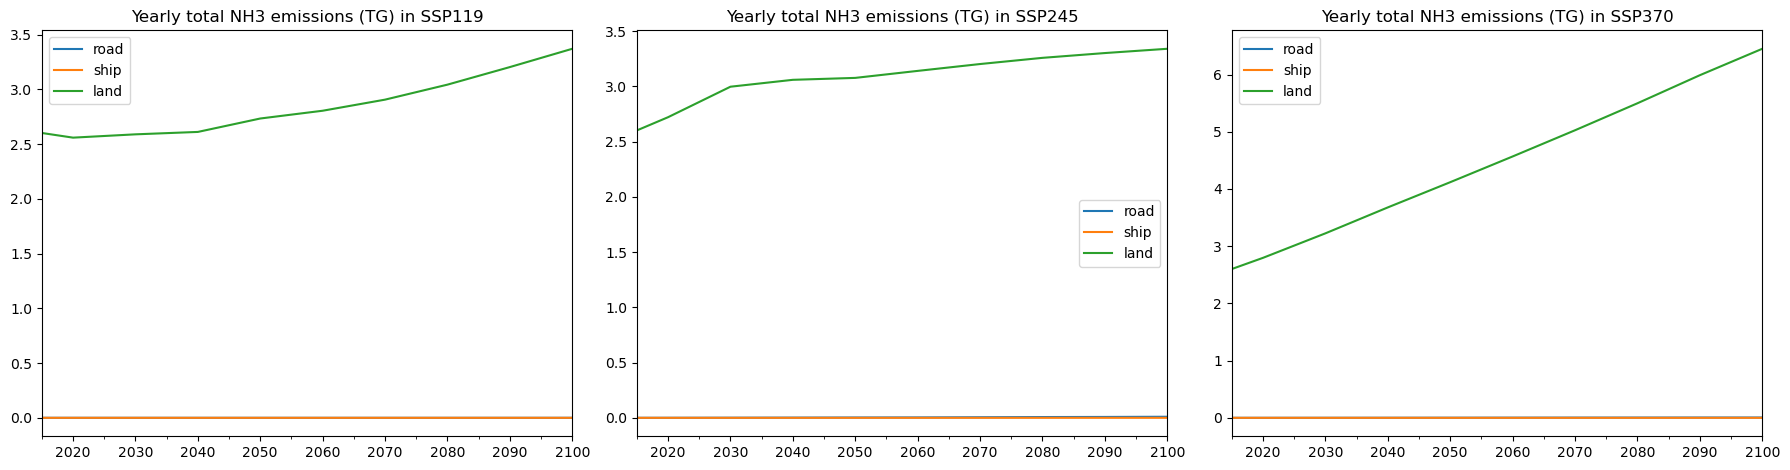

In [50]:
fig8, axs8 = plt.subplots(1,3)
fig8.set_figwidth(18)

emissions_NH3_ssp119.plot(title = 'Yearly total NH3 emissions (TG) in SSP119', ax= axs8[0])
emissions_NH3_ssp245.plot(title = 'Yearly total NH3 emissions (TG) in SSP245', ax= axs8[1])
emissions_NH3_ssp370.plot(title = 'Yearly total NH3 emissions (TG) in SSP370', ax= axs8[2])

fig8.tight_layout()

### NOx, across scenarios, for different categories

In [51]:
emissions_NOx_ssp119 = pd.DataFrame({'road': NOx_ssp119_road_yearly_global_weighted_averages,
                             'ship': NOx_ssp119_ship_yearly_global_weighted_averages,
                             'land': NOx_ssp119_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NOx_ssp245 = pd.DataFrame({'road': NOx_ssp245_road_yearly_global_weighted_averages,
                             'ship': NOx_ssp245_ship_yearly_global_weighted_averages,
                             'land': NOx_ssp245_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_NOx_ssp370 = pd.DataFrame({'road': NOx_ssp370_road_yearly_global_weighted_averages,
                             'ship': NOx_ssp370_ship_yearly_global_weighted_averages,
                             'land': NOx_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))

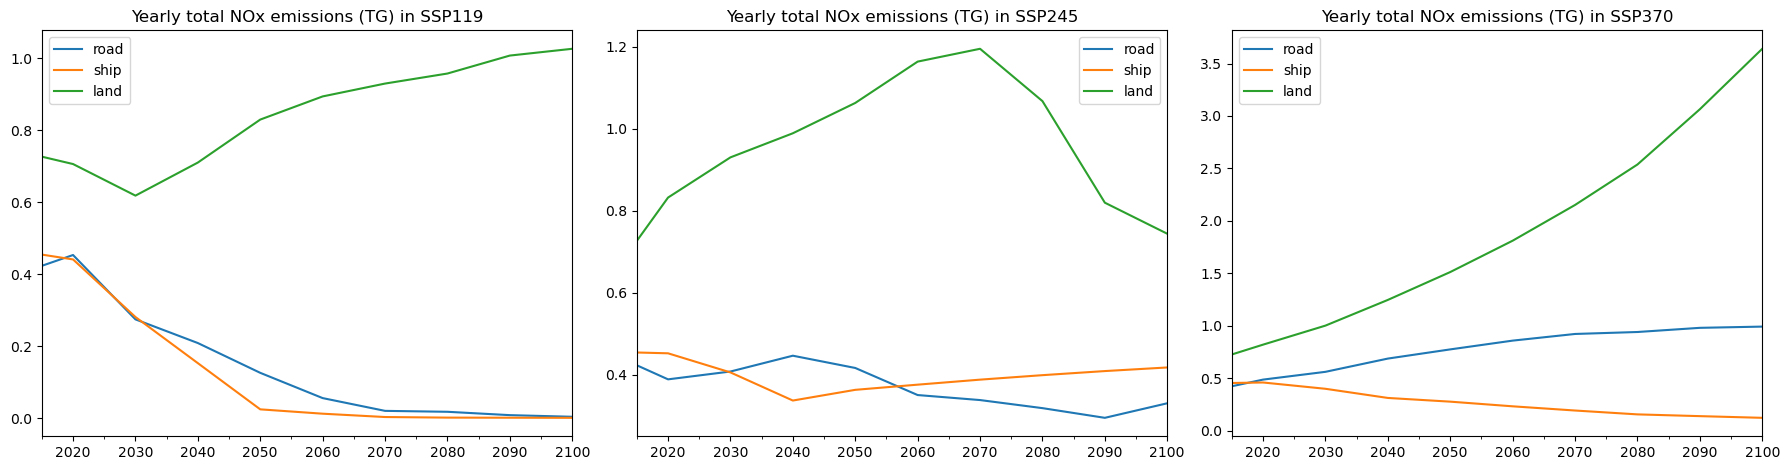

In [52]:
fig9, axs9 = plt.subplots(1,3)
fig9.set_figwidth(18)

emissions_NOx_ssp119.plot(title = 'Yearly total NOx emissions (TG) in SSP119', ax= axs9[0])
emissions_NOx_ssp245.plot(title = 'Yearly total NOx emissions (TG) in SSP245', ax= axs9[1])
emissions_NOx_ssp370.plot(title = 'Yearly total NOx emissions (TG) in SSP370', ax= axs9[2])

fig9.tight_layout()

### SO2, across scenarios, for different categories

In [53]:
emissions_SO2_ssp119 = pd.DataFrame({'road': SO2_ssp119_road_yearly_global_weighted_averages,
                             'ship': SO2_ssp119_ship_yearly_global_weighted_averages,
                             'land': SO2_ssp119_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_SO2_ssp245 = pd.DataFrame({'road': SO2_ssp245_road_yearly_global_weighted_averages,
                             'ship': SO2_ssp245_ship_yearly_global_weighted_averages,
                             'land': SO2_ssp245_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))
emissions_SO2_ssp370 = pd.DataFrame({'road': SO2_ssp370_road_yearly_global_weighted_averages,
                             'ship': SO2_ssp370_ship_yearly_global_weighted_averages,
                             'land': SO2_ssp370_land_yearly_global_weighted_averages},
                           index=pd.date_range("1/1/2015", periods=86, freq='Y'))

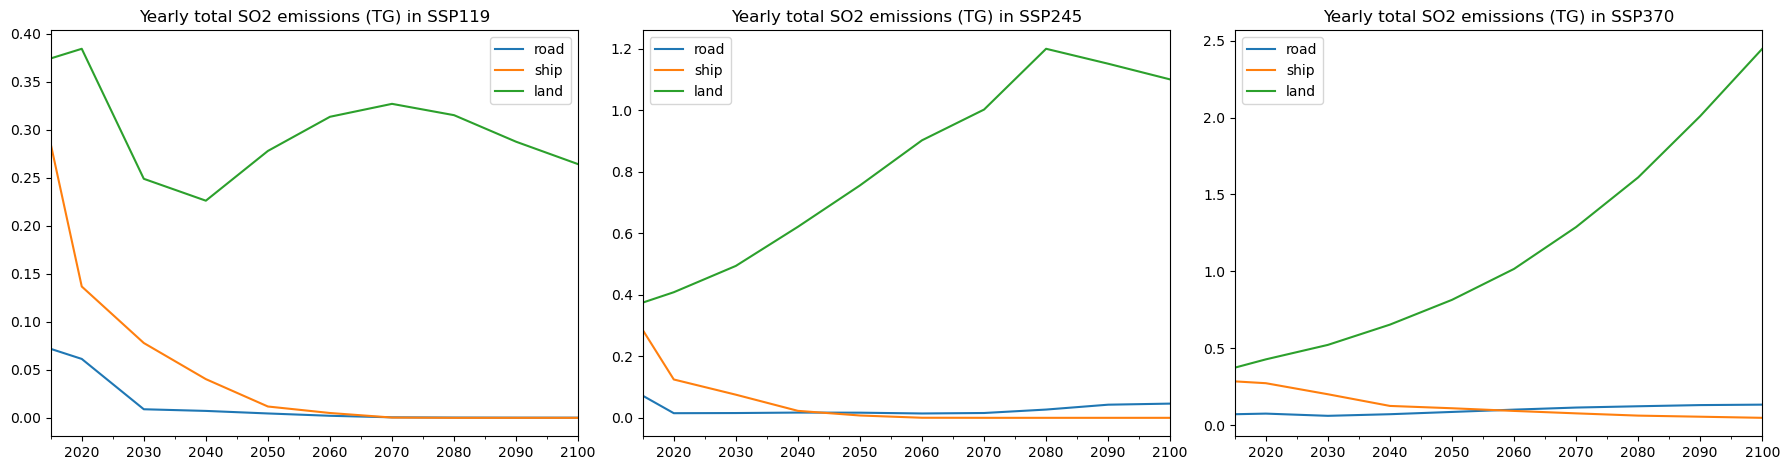

In [54]:
fig10, axs10 = plt.subplots(1,3)
fig10.set_figwidth(18)

emissions_SO2_ssp119.plot(title = 'Yearly total SO2 emissions (TG) in SSP119', ax= axs10[0])
emissions_SO2_ssp245.plot(title = 'Yearly total SO2 emissions (TG) in SSP245', ax= axs10[1])
emissions_SO2_ssp370.plot(title = 'Yearly total SO2 emissions (TG) in SSP370', ax= axs10[2])

fig10.tight_layout()